# TPCC OU Data Collection

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import lightgbm as lgb
from datetime import datetime
from pathlib import Path
from scipy import stats

In [2]:
BENCHMARK_NAME = "tpcc"
results_dir = Path.home() / "postgres/cmudb/tscout/results/" / BENCHMARK_NAME
results_dir

PosixPath('/home/gh/postgres/cmudb/tscout/results/tpcc')

In [3]:
# experiment_dirs = sorted(list(results_dir.glob("*")))

In [4]:
exp_name = "2021-11-08_04-26-47"
exp_dir = results_dir / exp_name
result_filepaths = list(exp_dir.glob("**/*.csv"))
print(exp_dir)

/home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47


#### Load Data

In [5]:
ou_name_to_df = dict()
run_id = 1

for filepath in result_filepaths:
    ou_name = filepath.stem
    
    if run_id != int(filepath.parent.stem): 
        continue
    
    if os.stat(filepath).st_size > 0:
        print(f"Loading filepath: {filepath}")
        ou_name_to_df[ou_name] = pd.read_csv(filepath)

Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecIndexScan.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecLockRows.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecNestLoop.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecResult.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecLimit.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecSort.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecAgg.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecValuesScan.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecSeqScan.csv
Loading filepath: /home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_04-26-47/1/ExecModifyTable.csv

In [6]:
for (ou_name, ou_df) in ou_name_to_df.items():
    print(f"OU Name: {ou_name}, ou_df shape: {ou_df.shape}")

OU Name: ExecIndexScan, ou_df shape: (919577, 40)
OU Name: ExecLockRows, ou_df shape: (204307, 35)
OU Name: ExecNestLoop, ou_df shape: (14954, 38)
OU Name: ExecResult, ou_df shape: (94871, 36)
OU Name: ExecLimit, ou_df shape: (27500, 40)
OU Name: ExecSort, ou_df shape: (15058, 41)
OU Name: ExecAgg, ou_df shape: (25882, 59)
OU Name: ExecValuesScan, ou_df shape: (117102, 36)
OU Name: ExecSeqScan, ou_df shape: (51935, 35)
OU Name: ExecModifyTable, ou_df shape: (140277, 43)
OU Name: ExecIndexOnlyScan, ou_df shape: (21897, 40)


# Pre-processing

#### Get IndexScan OU Data

In [13]:
target_ou = 'ExecIndexOnlyScan'
df = ou_name_to_df[target_ou]

### Remove Start/End Time (since elapsed_us == end_time - start_time)

In [14]:
cols_to_remove = ['start_time', 'end_time', 'cpu_id', 'query_id']
df = df.drop(cols_to_remove, axis=1)

#### Remove constant columns

In [15]:
cols_to_remove = []
for col in df.columns:
    if df[col].nunique() == 1: 
            cols_to_remove.append(col)

df = df.drop(cols_to_remove, axis=1)
print(f"Dropped zero-variance columns: {cols_to_remove}")
print(f"Num Remaining: {len(df.columns)}, Num Removed {len(cols_to_remove)}")

Dropped zero-variance columns: ['IndexOnlyScanState_ss_ps_type', 'IndexOnlyScanState_ss_ps_async_capable', 'IndexOnlyScanState_ss_ps_scanopsfixed', 'IndexOnlyScanState_ss_ps_outeropsfixed', 'IndexOnlyScanState_ss_ps_inneropsfixed', 'IndexOnlyScanState_ss_ps_resultopsfixed', 'IndexOnlyScanState_ss_ps_scanopsset', 'IndexOnlyScanState_ss_ps_outeropsset', 'IndexOnlyScanState_ss_ps_inneropsset', 'IndexOnlyScanState_ss_ps_resultopsset', 'IndexOnlyScanState_ioss_NumOrderByKeys', 'IndexOnlyScanState_ioss_RuntimeKeysReady', 'IndexOnlyScanState_ioss_PscanLen', 'Plan_type', 'Plan_plan_width', 'Plan_parallel_aware', 'Plan_parallel_safe', 'Plan_async_capable', 'ref_cpu_cycles', 'network_bytes_read', 'network_bytes_written', 'disk_bytes_read', 'disk_bytes_written', 'memory_bytes']
Num Remaining: 12, Num Removed 24


### Summarize Features

In [16]:
feat_cols = [col for col in df.columns if col not in ['cpu_cycles', 'instructions', 'cache_references', 'cache_misses', 'ref_cpu_cycles', 'network_bytes_read', 'network_bytes_written', 'disk_bytes_read', 'disk_bytes_written', 'memory_bytes', 'elapsed_us']]
features = df[feat_cols]
features.describe()

,IndexOnlyScanState_ioss_NumScanKeys,IndexOnlyScanState_ioss_NumRuntimeKeys,IndexOnlyScanState_ioss_VMBuffer,Plan_startup_cost,Plan_total_cost,Plan_plan_rows,Plan_plan_node_id
count,21897.000000,21897.000000,21897.000000,21897.000000,21897.000000,21897.000000,21897.000000
mean,2.426268,2.426268,3478.112892,0.286066,31.363591,337.226972,0.573732
std,0.494545,0.494545,4650.911661,0.001236,30.844675,449.823925,0.494545
min,2.000000,2.000000,0.000000,0.285000,8.305000,1.000000,0.000000
25%,2.000000,2.000000,0.000000,0.285000,8.310000,1.000000,0.000000
50%,2.000000,2.000000,0.000000,0.285000,8.310000,1.000000,1.000000
75%,3.000000,3.000000,9697.000000,0.287500,72.627500,939.000000,1.000000
max,3.000000,3.000000,9697.000000,0.287500,72.627500,939.000000,1.000000


### Summarize Targets

In [76]:
targets = df[target_cols]
targets.describe()

,cpu_cycles,instructions,cache_references,cache_misses,disk_bytes_written,elapsed_us
count,9.168830e+05,9.168830e+05,916883.000000,916883.000000,916883.000000,916883.000000
mean,2.495882e+04,5.607674e+04,1696.562491,571.306750,0.000122,5.183773
std,8.810992e+04,2.709513e+05,1659.352567,734.677056,0.044209,20.201163
min,3.498000e+03,5.423000e+03,180.000000,0.000000,0.000000,0.000000
25%,4.519000e+03,6.292000e+03,462.000000,48.000000,0.000000,1.000000
50%,1.166500e+04,1.919300e+04,1470.000000,124.000000,0.000000,2.000000
75%,2.149300e+04,2.358900e+04,2554.000000,1183.000000,0.000000,4.000000
max,4.074786e+06,7.245397e+06,58588.000000,16009.000000,16.000000,967.000000


## Show Features

In [77]:
features.head(5)

,IndexScanState_iss_NumScanKeys,IndexScanState_iss_NumRuntimeKeys,IndexScanState_iss_RuntimeKeysReady,IndexScanState_iss_ReachedEnd,Plan_startup_cost,Plan_total_cost,Plan_plan_rows,Plan_plan_width,Plan_parallel_safe,Plan_plan_node_id
0,2,2,1,1,0.2875,8.32,1.0,32,0,1
1,2,2,1,0,0.2875,8.32,1.0,32,0,1
2,2,2,1,1,0.2875,8.32,1.0,32,0,1
3,2,2,1,0,0.2875,8.32,1.0,32,0,1
4,2,2,1,1,0.2875,8.32,1.0,32,0,1


## Show targets

In [78]:
targets.head(5)

,cpu_cycles,instructions,cache_references,cache_misses,disk_bytes_written,elapsed_us
0,5099,5476,668,170,0,1
1,16216,20582,2075,642,0,4
2,4503,5476,513,54,0,0
3,13486,20578,1915,363,0,3
4,4215,5476,478,34,0,1


In [79]:
def plot_histograms(df): 
    for col_name in df.columns: 
        res = stats.relfreq(df[col_name], numbins=10)
        x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                         res.frequency.size)
        fig = plt.figure(figsize=(6, 2))
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(x, res.frequency, width=res.binsize)
        ax.set_title(col_name)
        ax.set_xlim([x.min(), x.max()])

#### Visualizations

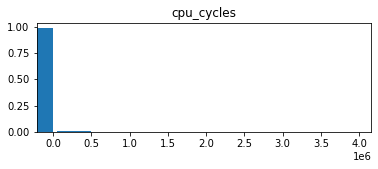

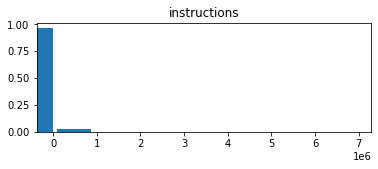

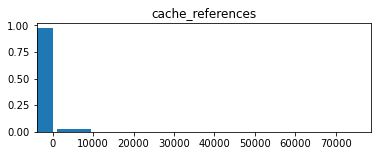

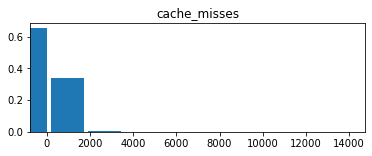

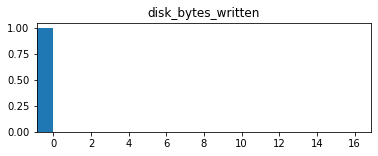

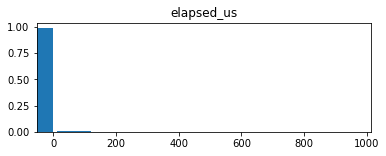

In [62]:
plot_histograms(targets)

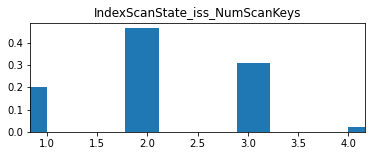

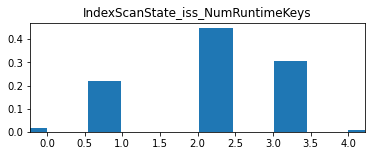

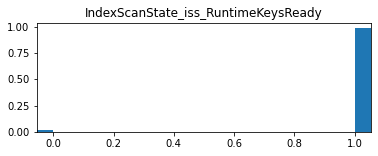

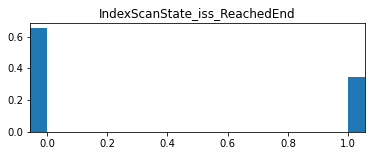

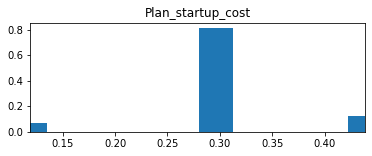

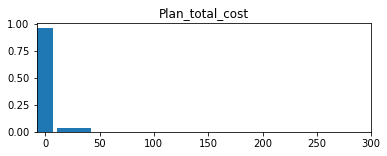

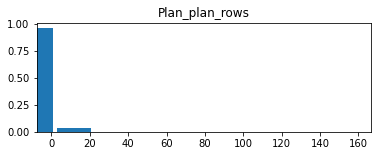

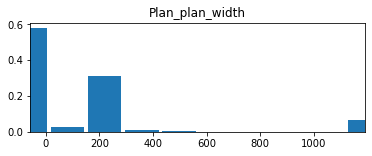

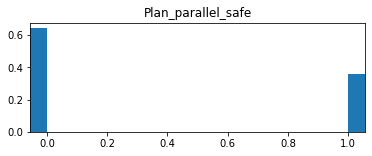

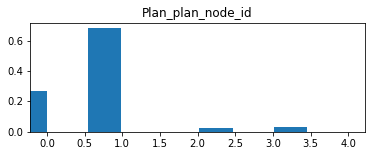

In [63]:
plot_histograms(features)

#### Correlation Heatmap

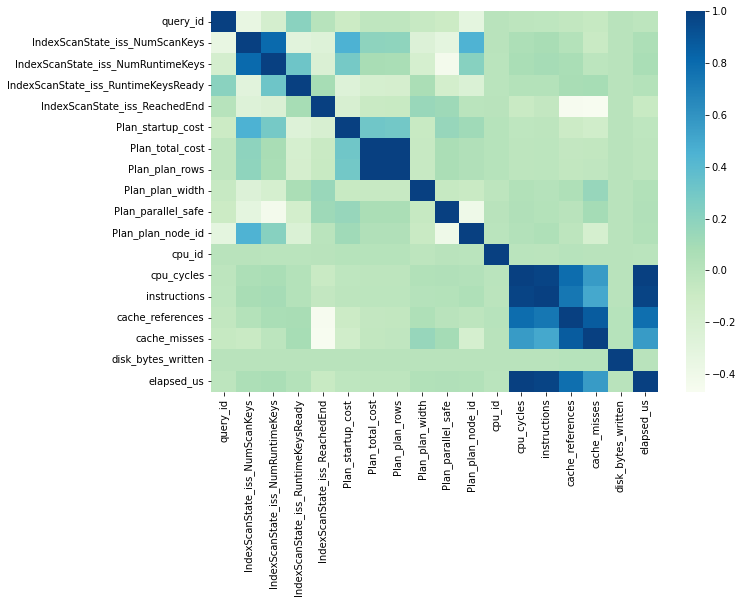

In [64]:
df_corr = df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(df_corr, cmap='GnBu')
plt.show()

# Feature Analysis - PCA

In [65]:
def pca_summary(df):
    pca = PCA(n_components=None)
    pca.fit(df)
    print(f"Input Dimensionality: {len(df.columns)}")
    for component_idx, explained_var_pct in enumerate(pca.explained_variance_ratio_):
        print(f"Component {component_idx} explains {round(explained_var_pct*100, 2)}% of variance")

In [66]:
features.columns

Index(['IndexScanState_iss_NumScanKeys', 'IndexScanState_iss_NumRuntimeKeys',
       'IndexScanState_iss_RuntimeKeysReady', 'IndexScanState_iss_ReachedEnd',
       'Plan_startup_cost', 'Plan_total_cost', 'Plan_plan_rows',
       'Plan_plan_width', 'Plan_parallel_safe', 'Plan_plan_node_id'],
      dtype='object')

In [67]:
pca_summary(features)

Input Dimensionality: 10
Component 0 explains 99.94% of variance
Component 1 explains 0.06% of variance
Component 2 explains 0.0% of variance
Component 3 explains 0.0% of variance
Component 4 explains 0.0% of variance
Component 5 explains 0.0% of variance
Component 6 explains 0.0% of variance
Component 7 explains 0.0% of variance
Component 8 explains 0.0% of variance
Component 9 explains 0.0% of variance


In [68]:
scanstate_feats = ['IndexScanState_iss_NumScanKeys', 'IndexScanState_iss_NumRuntimeKeys', 'IndexScanState_iss_RuntimeKeysReady']
pca_summary(features[scanstate_feats])

Input Dimensionality: 3
Component 0 explains 88.96% of variance
Component 1 explains 10.96% of variance
Component 2 explains 0.08% of variance


In [69]:
plancost_feats = ['Plan_startup_cost', 'Plan_total_cost']
pca_summary(features[plancost_feats])

Input Dimensionality: 2
Component 0 explains 99.99% of variance
Component 1 explains 0.01% of variance
